# Anomaly Detection on MNIST
 - https://benjoe.medium.com/
 - https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
 - https://www.kaggle.com/code/ninanovikova/real-fake-face-classification-and-visualization

In [1]:
import random

import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_file = '/content/drive/MyDrive/01. 강의/2024.09 AI Systems/Anomaly Detection/code/data/mnist_train.csv'
test_file = '/content/drive/MyDrive/01. 강의/2024.09 AI Systems/Anomaly Detection/code/data/mnist_test.csv'

In [5]:
df = pd.read_csv(test_file)

In [6]:
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
anom = df[:1000]
clean = df[1000:]

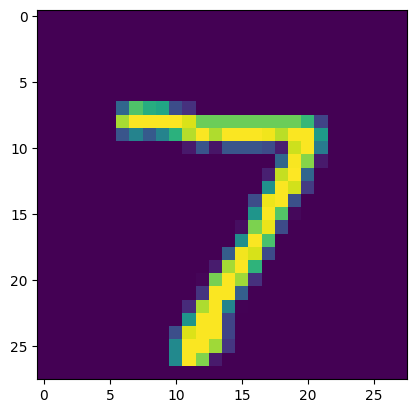

In [8]:
plt.imshow(np.array(anom.iloc[0].tolist()[1:]).reshape((28, 28)))

In [9]:
for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element 여기에 노이즈를 추가해서 anom예제를 임의로 만들음
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

<ipython-input-9-1e77797a6e69>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[i+1] = min(255, row[i+1]+random.randint(100,200))
<ipython-input-9-1e77797a6e69>:7: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[i+1] = min(255, row[i+1]+random.randint(100,200))


In [10]:
anom['label'] = 1
clean['label'] = 0

<ipython-input-10-7803411b1b46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anom['label'] = 1
<ipython-input-10-7803411b1b46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['label'] = 0


In [11]:
anom

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,1,167,108,196,140,135,182,133,136,143,...,176,153,126,109,141,136,196,113,151,131
1,1,182,151,121,137,161,101,118,156,128,...,144,193,188,147,105,190,147,187,159,141
2,1,184,184,193,149,104,159,123,167,150,...,124,199,150,148,196,191,194,198,147,185
3,1,182,120,160,164,180,166,130,174,128,...,166,200,102,193,102,168,139,143,163,139
4,1,191,121,137,193,148,111,119,141,195,...,192,171,147,177,159,200,133,186,198,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,111,153,132,159,169,173,171,163,111,...,111,140,184,157,166,127,139,178,166,123
996,1,147,139,161,153,198,168,188,195,159,...,136,132,181,122,185,100,117,138,122,182
997,1,111,111,169,135,128,124,196,129,174,...,191,157,123,120,149,123,119,128,178,140
998,1,151,180,189,142,104,162,178,108,143,...,154,101,175,107,113,122,198,170,113,124


In [12]:
anom.iloc[0].tolist()

[1,
 167,
 108,
 196,
 140,
 135,
 182,
 133,
 136,
 143,
 132,
 100,
 177,
 176,
 191,
 100,
 188,
 150,
 178,
 150,
 146,
 131,
 188,
 141,
 147,
 128,
 159,
 103,
 132,
 166,
 153,
 177,
 159,
 135,
 120,
 119,
 182,
 135,
 138,
 125,
 192,
 111,
 105,
 134,
 161,
 158,
 181,
 132,
 128,
 128,
 166,
 180,
 184,
 158,
 197,
 132,
 127,
 178,
 105,
 188,
 145,
 102,
 157,
 148,
 189,
 129,
 196,
 104,
 188,
 138,
 146,
 188,
 160,
 135,
 152,
 131,
 157,
 167,
 162,
 193,
 185,
 170,
 141,
 124,
 101,
 168,
 192,
 195,
 186,
 196,
 192,
 187,
 130,
 122,
 191,
 160,
 112,
 179,
 189,
 195,
 180,
 115,
 108,
 117,
 169,
 172,
 182,
 160,
 184,
 135,
 126,
 128,
 197,
 111,
 111,
 121,
 144,
 167,
 127,
 122,
 101,
 170,
 157,
 164,
 171,
 156,
 196,
 157,
 134,
 187,
 176,
 103,
 117,
 135,
 139,
 152,
 100,
 198,
 187,
 171,
 130,
 102,
 109,
 164,
 146,
 177,
 138,
 121,
 150,
 169,
 118,
 127,
 105,
 151,
 130,
 199,
 147,
 160,
 126,
 156,
 148,
 127,
 172,
 157,
 131,
 175,
 126,


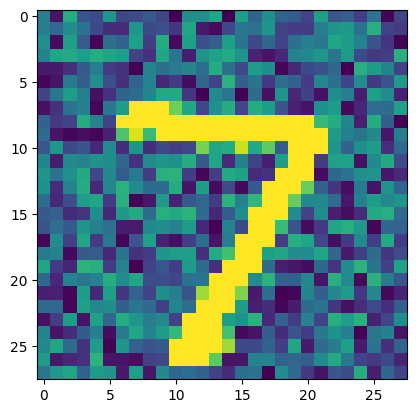

In [13]:
plt.imshow(np.array(anom.iloc[0].tolist()[1:]).reshape((28, 28)))

In [14]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('anom.csv')          # save

In [15]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = ## 모델 구조를 구현하세요
        self.dec = ## 모델 구조를 구현하세요
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [16]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9
epochs = 15

In [17]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        #row = row.drop(labels={'label'}, axis=1)
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        return data


class Train_Loader(Loader):
    def __init__(self, train_file):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       train_file,
                       index_col=False
                       )

## 노이즈가 없는 원본데이터인 Train_file로 학습

In [18]:
train_set = Train_Loader(train_file)
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=20,
            pin_memory=True,
            drop_last=True
        )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [20]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.0033615936738749345
Epoch Complete in 0:00:45.950040
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.003268058701356252
Epoch Complete in 0:00:46.652732
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.0031712156449755034
Epoch Complete in 0:00:40.517113
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.003065024135510127
Epoch Complete in 0:00:40.318892
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.002950954560066263
Epoch Complete in 0:00:47.973656
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.0028403174887100856
Epoch Complete in 0:00:45.399865
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.0027476349014788864
Epoch Complete in 0:00:44.087117
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.0026796272644152245
Epoch Complete in 0:00:40.244009
-------------------

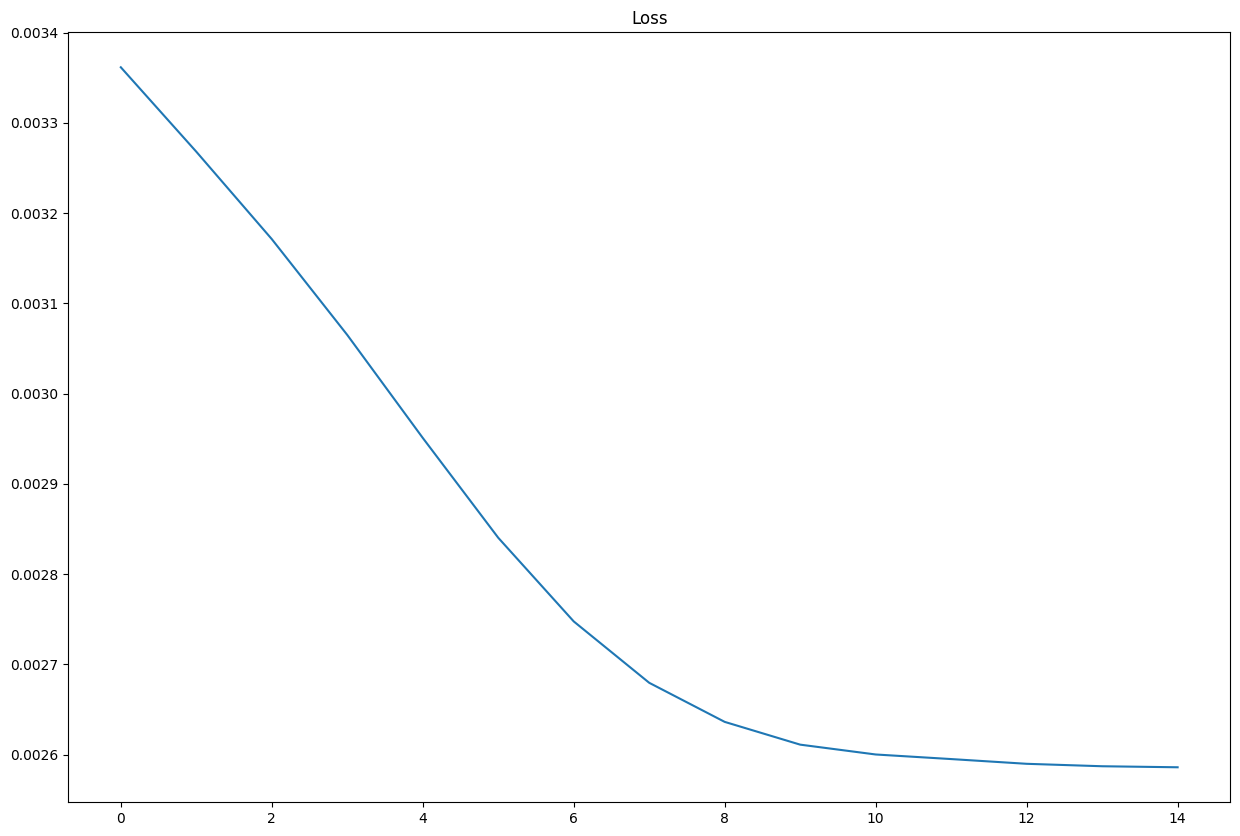

In [21]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

## 02. 정상+노이즈가낀 데이터가 섞여있는 anom.csv 데이터로 **각 샘플별** loss를 확인

In [22]:
model.eval()
loss_dist = []
anom = pd.read_csv('./anom.csv', index_col=[0])
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

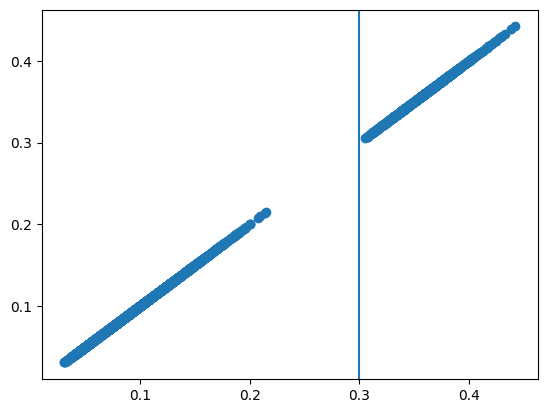

In [23]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

<ipython-input-24-3e4574cc40a6>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(loss_dist,bins=100,kde=True, color='blue')


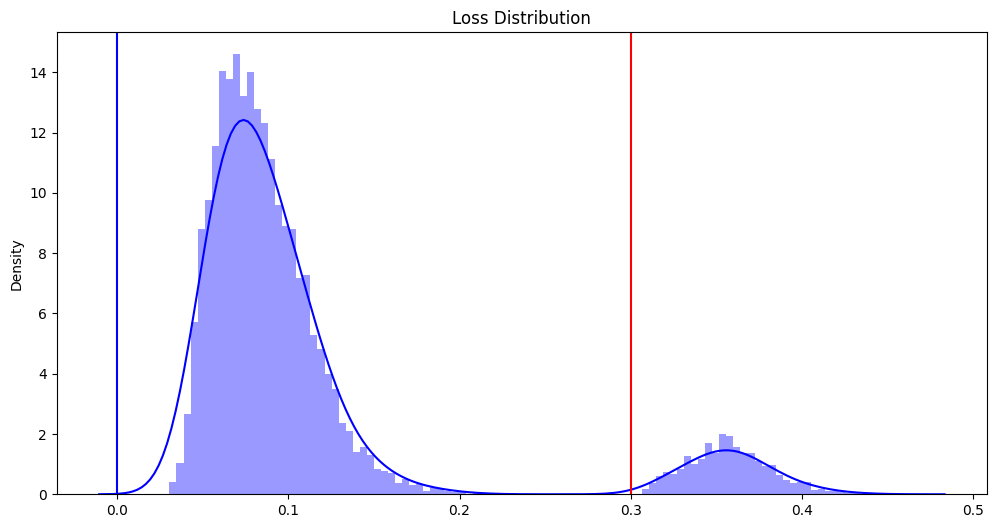

In [24]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [25]:
df = pd.read_csv('./anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0


<Axes: >

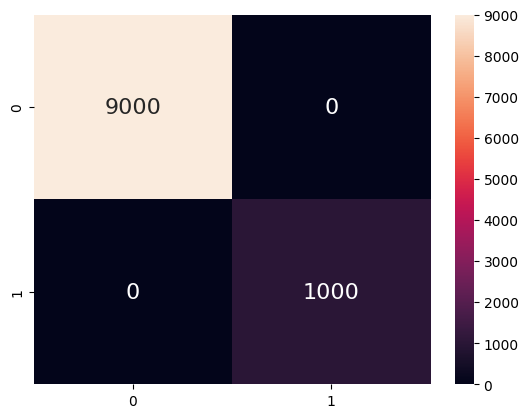

In [26]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

In [27]:
df = pd.read_csv("/content/drive/MyDrive/01. 강의/2024.09 AI Systems/Anomaly Detection/code/fps_anomi_train.csv")

In [28]:
df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,...,1,591.3,0,0.00,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0.0,0,0.00,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,...,1,0.0,0,0.00,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0.0,0,0.00,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0.0,0,0.00,0,0,640.80,4,1475,0.5217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357331,6224518,1652603,47575,0,5,196.40,2,0,4,28,...,1,2721.0,0,24.56,0,0,3070.00,3,1475,0.8929
4357332,6224519,1653346,47592,2,2,358.10,4,3,2,7,...,0,0.0,0,0.00,0,0,2820.00,6,1484,0.7241
4357333,6224520,1657176,47679,0,3,559.00,4,1,3,8,...,0,0.0,0,0.00,1,0,400.60,2,1500,0.4483
4357334,6224521,1658403,47707,0,0,100.00,0,0,0,89,...,0,0.0,0,0.00,1,0,68.82,1,1502,0.1429


In [29]:
# ▶ headshot 100% 유저 탐색
df['_headshot_rate'] = df['headshotKills']/df['kills']
df['_headshot_rate'] = df['_headshot_rate'].fillna(0)
df_3 = df[df['_headshot_rate'] == 1]
print(len(df_3))
df[df['_headshot_rate'] == 1].head()

266984


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_headshot_rate
1,1,440875,1,1,0,37.65,1,1,0,45,...,0.0,0,0.00,0,0,119.6,3,1511,0.0400,1.0
10,10,45059,10,0,1,166.00,0,1,1,35,...,0.0,0,0.00,0,0,184.5,3,1500,0.4536,1.0
32,32,1010453,32,0,3,214.90,1,2,4,19,...,1576.0,0,0.00,0,0,1526.0,3,1502,0.7292,1.0
33,33,1054979,33,0,0,166.20,1,1,0,37,...,0.0,0,0.00,0,0,133.1,2,1544,0.2414,1.0
50,50,1802026,50,0,3,360.30,3,2,15,15,...,0.0,0,75.86,0,0,2669.0,6,1480,0.6800,1.0


In [30]:
# ▶ 버그 의심 유저 검출
df_3[df_3['kills'] > 10][['kills', '_headshot_rate']].sort_values(by=['kills'], ascending =False)

,kills,_headshot_rate
3902972,17,1.0
2411348,13,1.0
3409867,13,1.0
3201166,13,1.0
4277997,12,1.0
458289,11,1.0
3204285,11,1.0
4242764,11,1.0


In [31]:
df = df[:int(len(df)/4)]

In [32]:
df_3 = df[df['_headshot_rate'] == 1]
print(len(df_3))
df[df['_headshot_rate'] == 1].head()

67324


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_headshot_rate
1,1,440875,1,1,0,37.65,1,1,0,45,...,0.0,0,0.00,0,0,119.6,3,1511,0.0400,1.0
10,10,45059,10,0,1,166.00,0,1,1,35,...,0.0,0,0.00,0,0,184.5,3,1500,0.4536,1.0
32,32,1010453,32,0,3,214.90,1,2,4,19,...,1576.0,0,0.00,0,0,1526.0,3,1502,0.7292,1.0
33,33,1054979,33,0,0,166.20,1,1,0,37,...,0.0,0,0.00,0,0,133.1,2,1544,0.2414,1.0
50,50,1802026,50,0,3,360.30,3,2,15,15,...,0.0,0,75.86,0,0,2669.0,6,1480,0.6800,1.0


In [33]:
# ▶ possible abuser
df_3[df_3['kills'] > 10][['kills', '_headshot_rate']].sort_values(by=['kills'], ascending =False)

,kills,_headshot_rate
458289,11,1.0


In [ ]:
df.to_csv("fps_anomi_data.csv")

# [과제] 고민해볼 만한 문제와 해결 방법

1.   게임 핵유저 검출 데이터를 분석해 이상 user를 정의해보세요
*   Data shape(형태) 확인
*   Data type 확인
*   Null값 확인 (※ 빈 값의 Data)
*   Outlier 확인 (※ 정상적인 범주를 벗어난 Data)
* 예) ▶ Total 이동 거리는 낮은데, headshot 비율이 높은 유저??

2.   이상 탐지를 모델링 하는 코드를 작성해보세요

> **데이터 살펴보기**

* FPS 게임 플레이 데이터
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|ID |ID|
|groupId |그룹ID|
|matchId |경기ID|
|assists |서포트횟수|
|boosts |부스트 아이템 사용횟수|
|damageDealt |총 입힌 데미지|
|DBNOs |적을 기절시킨 횟수|
|headshotKills |헤드샷킬수|
|heals |heal 아이템 사용횟수|
|killPlace |적을제압한위치|
|killPoints |적제압포인트|
|kills |적 제압횟수|
|killStreaks |가장 많이 적 제압횟수|
|longestKill |멀리서 적 제압횟수|
|maxPlace |최악의배치넘버|
|numGroups |그룹넘버|
|revives |부활횟수|
|rideDistance |이동수단 타고 이동거리|
|roadKills |이동수단으로 적 제압횟수|
|swimDistance|수영한거리|
|teamKills |같은팀 제압횟수|
|vehicleDestroys|자동차 파괴횟수|
|walkDistance|도보이동거리|
|weaponsAcquired|무기 획득횟수|
|winPoints|승점|
|winPlacePerc|승률|


